# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
# Locale settings
import locale
# Set to German locale to get comma decimal seperator
# Check with "locale -a" if "de_DE.utf8" is installed on your system
# Installation guide: https://ubuntuforums.org/showthread.php?t=196414
locale.setlocale(
    locale.LC_NUMERIC, "de_DE.utf8")

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import rgb2hex

# Tell matplotlib to use the locale
plt.rcParams['axes.formatter.use_locale'] = True

idx = pd.IndexSlice

# Plots

In [2]:
# Plot parameters
# Style
style = "whitegrid"
# Figure sizes
standard_sizes = {
    "a4portrait": (8.27, 11.69),
    "a4landscape": (11.69, 8.27),
    "a5portrait": (5.8, 8.3),
    "a5landscape": (8.3, 5.8),
}
# Font parameters
font = "sans-serif"
font_scale = 1.5
# Figure aesthetics
grid_linestyle = "--"
yticks = True
xticks = True

In [3]:
# Colors
def RGB_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

def rgb_to_RGB(rgb_tuple):
    return tuple(
        [int(round(255*val, 0)) for val in rgb_tuple])

palette = sns.color_palette("colorblind")


rgb_grid = (200, 200, 200)
rgb_labels = (0, 0, 0)


hex_grid = RGB_to_hex(*rgb_grid)
hex_labels = RGB_to_hex(*rgb_labels)

In [4]:
# Set seaborn parameters
rc_theme = {
    "grid.linestyle":grid_linestyle,
    "ytick.left":yticks,
    "xtick.bottom":xticks,
    "ytick.color":hex_grid,
    "ytick.labelcolor":hex_labels,
    "xtick.color":hex_grid,
    "xtick.labelcolor":hex_labels,
    "grid.color":hex_grid,
}

sns.set_theme(
    style=style, font=font, font_scale=font_scale, palette=palette, rc=rc_theme)

In [5]:
figure_export_as = ["png", "jpg"]
export_dir = "/home/kilian/rli/rl-institut/05_Temp/Kilian/open_bea/plots"

## Curtailment dumb

In [6]:
# curtailment results
base_dir = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/curtailment_results_weekly/{}/ego100/dumb"

files = {
    "gen_lv": "{}_curtailment_lv_ts_per_gen.csv",
    "load_lv": "{}_curtailment_lv_ts_per_load.csv",
    "gen_mvlv": "{}_curtailment_mvlv_ts_per_gen.csv",
    "load_mvlv": "{}_curtailment_mvlv_ts_per_load.csv",
    "gen_mv": "{}_curtailment_ts_per_gen.csv",
    "load_mv": "{}_curtailment_ts_per_load.csv"}

# topology

base_dir_topology = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/edisgo_files/{}/ego100/dumb/topology"

f_gens_top = "generators.csv"
f_cps_top = "charging_points.csv"

grid_ids = [176, 177, 1056, 1690, 1811, 2534]

weeks = ["max_rl", "min_rl"] 

scenario_tuples = [
    (grid_id, week) for grid_id in grid_ids for week in weeks]

In [7]:
levels = ["lv", "mvlv", "mv"]

technologies = ["vres", "other_gen", "evs", "other_loads"]

columns = [technology + "_" + level for technology in technologies for level in levels]

results_df = pd.DataFrame(
    data=0., columns=columns,
    index=pd.MultiIndex.from_tuples(scenario_tuples, names=["grid_id", "week"]))

vres = ["solar", "wind"]

gen_keys = ["gen_lv", "gen_mvlv", "gen_mv"]

vres_dict = {
    key: "vres_" + key.split("_")[-1] for key in gen_keys}

other_gens_dict = {
    key: "other_gen_" + key.split("_")[-1] for key in gen_keys}

load_keys = ["load_lv", "load_mvlv", "load_mv"]

ev_dict = {
    key: "evs_" + key.split("_")[-1] for key in load_keys}

other_loads_dict = {
    key: "other_loads_" + key.split("_")[-1] for key in load_keys}

for grid_id, week in tqdm(scenario_tuples):
    grid_dir = base_dir.format(grid_id)
    topo_dir = base_dir_topology.format(grid_id)
    
    grid_files = {
        key: os.path.join(grid_dir, val.format(week)) for key, val in files.items()}
    
    data = {
        key: pd.read_csv(
            val, index_col=0, parse_dates=True) for key, val in grid_files.items()}
    
    # gens
    generators_df = pd.read_csv(os.path.join(
        topo_dir, f_gens_top), index_col=0)
    
    vres_idx = generators_df.loc[
        generators_df.type.isin(vres)].index
    
    gen_files = {
        key: val for key, val in data.items() if "gen" in key}
    
    for key, df in gen_files.items():
        cur_total = df.sum().sum()
        cur_vres = df[vres_idx].sum().sum()
        
        results_df.at[idx[grid_id, week], vres_dict[key]] = cur_vres
        results_df.at[idx[grid_id, week], other_gens_dict[key]] = cur_total - cur_vres
    
    # loads
    cps_idx = pd.read_csv(os.path.join(
        topo_dir, f_cps_top), index_col=0).index
        
    load_files = {
        key: val for key, val in data.items() if not "gen" in key}
    
    for key, df in load_files.items():
        cur_total = df.sum().sum()
        cur_evs = df[cps_idx].sum().sum()
        
        results_df.at[idx[grid_id, week], ev_dict[key]] = cur_evs
        results_df.at[idx[grid_id, week], other_loads_dict[key]] = cur_total - cur_evs

        
results_df.iloc[:, 2::3] = (results_df.iloc[:, 2::3] - results_df.iloc[:, 1::3].values - results_df.iloc[:, 0::3].values)

results_df = results_df.divide(4).round(3)

results_df.iloc[:, int(results_df.shape[1]/2):] *= (-1)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.65s/it]


In [8]:
sorting_dict = {
    176: 3,
    177: 4,
    1056: 2,
    1690: 0,
    1811: 1,
    2534: 5}

results_df = results_df.assign(
    sortby=results_df.index.get_level_values("grid_id").map(sorting_dict))

results_df = results_df.sort_values(
    by="sortby", ascending=True).drop("sortby", axis=1)

In [9]:
legend_dict = {
    'vres_lv': "NS fEE",
    'vres_mvlv': "MS-NS fEE",
    'vres_mv': "MS fEE",
    'other_gen_lv': "NS Sonst.",
    'other_gen_mvlv': "MS-NS Sonst.",
    'other_gen_mv': "MS Sonst.",
    'evs_lv': "NS E-Pkw",
    'evs_mvlv': "MS-NS E-Pkw",
    'evs_mv': "MS E-Pkw",
    'other_loads_lv': "NS Sonst.",
    'other_loads_mvlv': "MS-NS Sonst.",
    'other_loads_mv': "MS Sonst."}

xaxis_names_orig = ['(1690, min_rl)', '(1811, min_rl)', '(1056, min_rl)', '(176, min_rl)', '(177, min_rl)', '(2534, min_rl)']
xaxis_names = [int(val.split(",")[0].split("(")[-1]) for val in xaxis_names_orig]

kind_dict = {
    176: "PV",
    177: "L",
    1056: "PV",
    1690: "W",
    1811: "W",
    2534: "L"}

naming_dict = {key: f"$\mathregular{{{xaxis_names[count]}_{{{kind_dict[xaxis_names[count]]}}}}}$"
               for count, key in enumerate(xaxis_names_orig)}
naming_dict

{'(1690, min_rl)': '$\\mathregular{1690_{W}}$',
 '(1811, min_rl)': '$\\mathregular{1811_{W}}$',
 '(1056, min_rl)': '$\\mathregular{1056_{PV}}$',
 '(176, min_rl)': '$\\mathregular{176_{PV}}$',
 '(177, min_rl)': '$\\mathregular{177_{L}}$',
 '(2534, min_rl)': '$\\mathregular{2534_{L}}$'}

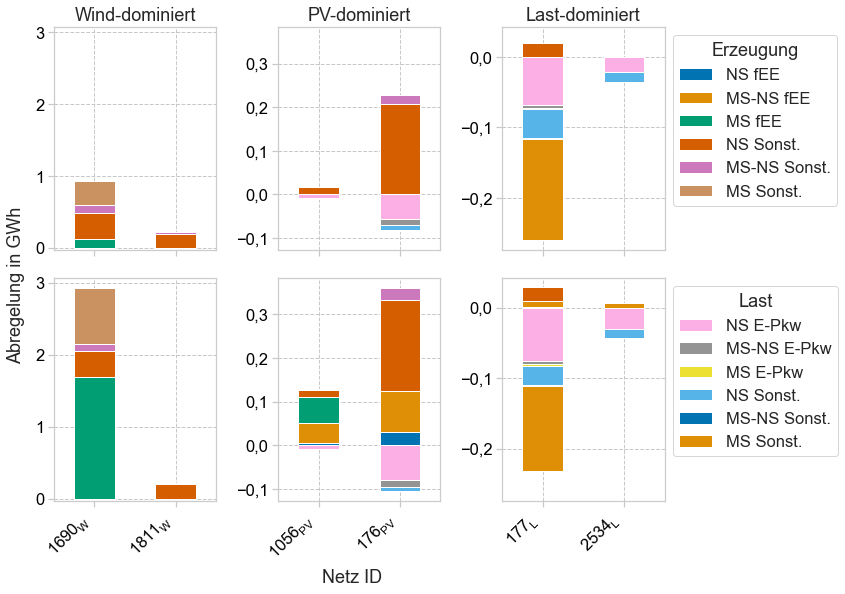

In [10]:
fig, axs = plt.subplots(
    2, 3, figsize=standard_sizes["a4landscape"], sharex="col")

grid_id_lists = [[1690, 1811], [1056, 176], [177, 2534]]

for count_weeks, week in enumerate(weeks):
    for count_grid_ids, grid_id_list in enumerate(grid_id_lists):
        ax = axs[count_weeks, count_grid_ids]

        plt_df = results_df.loc[
            idx[grid_id_list, week], :].divide(1000)

        plt_df.plot.bar(
            stacked=True, ax=ax)
        
        # axis labels
        ax.set_xlabel(None)
        
        # titles
        if count_weeks == 0:
            if count_grid_ids == 0:
                ax.set_title("Wind-dominiert")
            elif count_grid_ids == 1:
                ax.set_title("PV-dominiert")
            elif count_grid_ids == 2:
                ax.set_title("Last-dominiert")
                
        # xticks
        if count_weeks == 1:
            labels = [naming_dict[item.get_text()] for item in ax.get_xticklabels()]
            
            ax.set_xticklabels(labels, rotation=45, ha="right")
        
        # legend
        handles, labels = ax.get_legend_handles_labels()

        labels = [legend_dict[label] for label in labels]
        
        if count_weeks == 0 and count_grid_ids == 2:
            ax.legend(
                handles=handles[:int(len(handles)/2)], labels=labels[:int(len(handles)/2)],
                bbox_to_anchor=(1,1), loc="upper left", title="Erzeugung")

        elif count_weeks == 1 and count_grid_ids == 2:
            ax.legend(
                handles=handles[int(len(handles)/2):], labels=labels[int(len(handles)/2):],
                bbox_to_anchor=(1,1), loc="upper left", title="Last")

        else:
            ax.get_legend().remove()

fig.text(-0.01, 0.5, "Abregelung in GWh", va="center", rotation="vertical")
fig.text(0.40, -0.0, "Netz ID", ha="center")

# xlim
for i in range(axs.shape[1]):
    ax1 = axs[0, i]
    ax2 = axs[1, i]
        
    ylim1 = ax1.get_ylim()
    ylim2 = ax2.get_ylim()
    
    ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    
    if i == 1:
        ylim = (ylim[0] * 1.2, ylim[1])
        
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
        
plt.tight_layout()

for kind in figure_export_as:
    plt.savefig(
        os.path.join(export_dir, f"curtailment_dumb_detailed.{kind}"),
        dpi=450, bbox_inches="tight")
    
plt.show()

In [11]:
agg_results_df = pd.DataFrame(
    index=results_df.index, dtype="float64")

for technology in technologies:
    df = results_df[[col for col in results_df.columns if technology in col]].sum(axis=1).to_frame(name=technology)
    
    agg_results_df = agg_results_df.merge(
        df, how="left", left_index=True, right_index=True)

assert int(agg_results_df.sum().sum()) == int(results_df.sum().sum())

In [12]:
legend_dict = {
    'vres': "fEE",
    'other_gen': "Sonst. EE",
    'evs': "E-Pkw",
    'other_loads': "Sonst. Lasten"}

yaxis_label_dict = {
    "min_rl": "Niedrige Residuallast",
    "max_rl": "Hohe Residuallast"}

relevant_cols = ["vres", "evs", "other_loads"]

In [13]:
from matplotlib.ticker import MaxNLocator

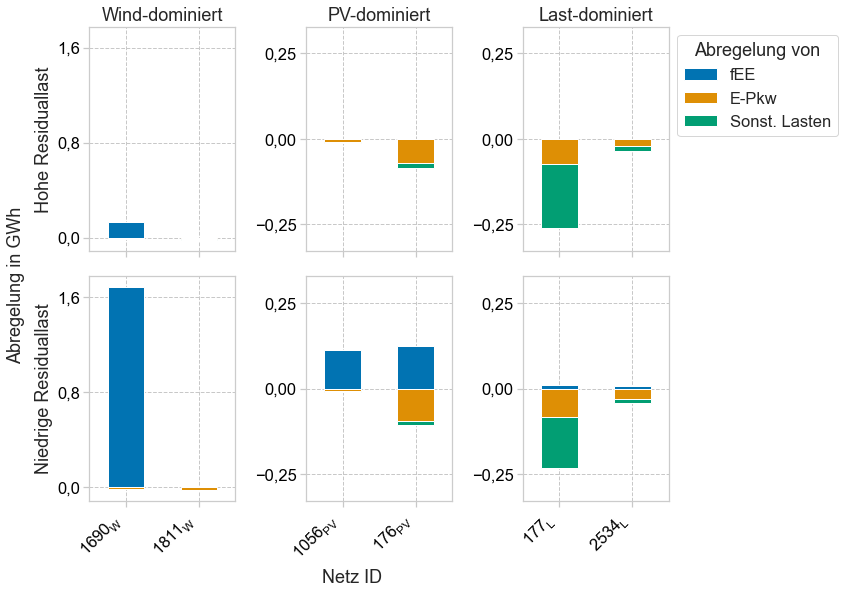

In [14]:
fig, axs = plt.subplots(
    2, 3, figsize=standard_sizes["a4landscape"], sharex="col")

grid_id_lists = [[1690, 1811], [1056, 176], [177, 2534]]

for count_weeks, week in enumerate(weeks):
    for count_grid_ids, grid_id_list in enumerate(grid_id_lists):
        ax = axs[count_weeks, count_grid_ids]

        plt_df = agg_results_df[relevant_cols].loc[
            idx[grid_id_list, week], :].divide(1000)

        plt_df.plot.bar(
            stacked=True, ax=ax)
        
        # axis labels
        ax.set_xlabel(None)
        
        if count_grid_ids == 0:
            ax.set_ylabel(yaxis_label_dict[week])
        
        # yticks
        ax.yaxis.set_major_locator(MaxNLocator(3)) 
        
        # titles
        if count_weeks == 0:
            if count_grid_ids == 0:
                ax.set_title("Wind-dominiert")
            elif count_grid_ids == 1:
                ax.set_title("PV-dominiert")
            elif count_grid_ids == 2:
                ax.set_title("Last-dominiert")
                
        # xticks
        if count_weeks == 1:
            labels = [naming_dict[item.get_text()] for item in ax.get_xticklabels()]
            
            ax.set_xticklabels(labels, rotation=45, ha="right")
        
        # legend        
        if count_weeks == 0 and count_grid_ids == 2:
            handles, labels = ax.get_legend_handles_labels()
            labels = [legend_dict[label] for label in labels]
            
            ax.legend(
                handles=handles, labels=labels,
                bbox_to_anchor=(1,1), loc="upper left", title="Abregelung von")

        else:
            ax.get_legend().remove()

fig.text(-0.01, 0.5, "Abregelung in GWh", va="center", rotation="vertical")
fig.text(0.40, -0.0, "Netz ID", ha="center")

# ylim
for i in range(axs.shape[1]):
    ax1 = axs[0, i]
    ax2 = axs[1, i]
        
    ylim1 = ax1.get_ylim()
    ylim2 = ax2.get_ylim()
    
    ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
    
    if i == 1:
        ylim = (ylim[0] * 1.2, ylim[1])
        
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)

for i in range(axs.shape[1]):
    ax1 = axs[0, i]
    ax2 = axs[1, i]

    ylim1 = ax1.get_ylim()
    ylim2 = ax2.get_ylim()
    
    if i == 0:
        ylim = (min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))

        if i == 1:
            ylim = (ylim[0] * 1.2, ylim[1])

        ax1.set_ylim(ylim)
        ax2.set_ylim(ylim)
        
        ylim = (0, 0)
        
    else:
        ylim1 = [abs(val) for val in ylim1]
        ylim2 = [abs(val) for val in ylim2]
        
        ylim_max = max(max(ylim), max(ylim1), max(ylim2))
        
        ylim = (-ylim_max*1.2, ylim_max*1.2)

for i in range(axs.shape[1]):
    if i == 0:
        pass
    else:
        ax1 = axs[0, i]
        ax2 = axs[1, i]
        
        ax1.set_ylim(ylim)
        ax2.set_ylim(ylim)
        
plt.tight_layout()

for kind in figure_export_as:
    plt.savefig(
        os.path.join(export_dir, f"curtailment_dumb.{kind}"),
        dpi=450, bbox_inches="tight")
    
plt.show()

## Curtailment plots strategies + solar storage

In [15]:
# curtailment results
base_dir = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/{}/{}/ego100/{}"


f_per_gen = "{}_curtailment_ts_per_gen.csv"
f_per_load = "{}_curtailment_ts_per_load.csv"

# topology

base_dir_topology = "/home/kilian/rli/PC50/storage/open_bea_calculations_v4/edisgo_files/{}/ego100/{}/topology"

f_gens_top = "generators.csv"
f_cps_top = "charging_points.csv"

curtailment_dirs = [
    "curtailment_results_weekly", "curtailment_results_weekly_with_solar_storage"]

grid_ids = [176, 177, 1056, 1690, 1811, 2534]

strategies = ["dumb", "reduced", "residual"]

weeks = ["max_rl", "min_rl"] 

scenario_tuples = [
    (curtailment_dir, grid_id, strategy, week)
    for curtailment_dir in curtailment_dirs 
    for grid_id in grid_ids for strategy in strategies for week in weeks]

In [16]:
vres = ["solar", "wind"]

results_df = pd.DataFrame(
    data=0., index=pd.MultiIndex.from_tuples(scenario_tuples, names=[
        "curtailment_dir", "grid_id", "strategy", "week"]),
    columns=["curtailment_vres", "curtailment_evs", "curtailment_loads"]
)

for curtailment_dir, grid_id, strategy, week in tqdm(scenario_tuples):
    try:
        # curtailment generation
        f_gen = f_per_gen.format(week)

        df_gen_ts = pd.read_csv(os.path.join(
            base_dir.format(
                curtailment_dir, grid_id, strategy), f_gen), index_col=0, parse_dates=True)

        df_gens_top = pd.read_csv(os.path.join(
            base_dir_topology.format(grid_id, strategy), f_gens_top), index_col=0)

        vres_idx = df_gens_top.loc[df_gens_top.type.isin(vres)].index

        df_vres_ts = df_gen_ts.loc[:, vres_idx]

        results_df.at[(curtailment_dir, grid_id, strategy, week), "curtailment_vres"] = \
            df_vres_ts.sum().sum()

        # curtailment load
        f_load = f_per_load.format(week)

        df_load_ts = pd.read_csv(os.path.join(
            base_dir.format(
                curtailment_dir, grid_id, strategy), f_load), index_col=0, parse_dates=True)

        cps_index = pd.read_csv(os.path.join(
            base_dir_topology.format(grid_id, strategy), f_cps_top), index_col=0).index

        df_cps_ts = df_load_ts.loc[:, cps_index]

        df_loads_ts = df_load_ts.loc[:, [col for col in df_load_ts.columns if col not in cps_index]]

        results_df.at[(curtailment_dir, grid_id, strategy, week), "curtailment_evs"] = \
            -df_cps_ts.sum().sum()

        results_df.at[(curtailment_dir, grid_id, strategy, week), "curtailment_loads"] = \
            -df_loads_ts.sum().sum()
    except:
        continue

results_df /= 4

100%|█████████████████████████████████████████████████████████████████████████████████| 72/72 [01:04<00:00,  1.11it/s]


In [37]:
idx = pd.IndexSlice

results_diff_df = results_df.copy()

results_diff_df.loc[:, ["curtailment_evs", "curtailment_loads"]] *= (-1)

for grid_id in grid_ids:
    for week in weeks:        
        sli = results_diff_df.loc[
            idx[:, grid_id, :, week]]
        
        results_diff_df.loc[
            idx[:, grid_id, :, week], :] = sli.values - sli.iloc[0].values

results_diff_df = results_diff_df.drop(
    results_diff_df.loc[idx["curtailment_results_weekly", :, "dumb"]].index)

In [38]:
idx = pd.IndexSlice

results_diff_percental_df = results_df.copy()

results_diff_percental_df.loc[:, ["curtailment_evs", "curtailment_loads"]] *= (-1)

for grid_id in grid_ids:
    for week in weeks:
        sli = results_diff_percental_df.loc[
            idx[:, grid_id, :, week]]

        results_diff_percental_df.loc[
            idx[:, grid_id, :, week], :] = (sli.values / sli.iloc[0].values - 1) * 100

results_diff_percental_df = results_diff_percental_df.drop(
    results_diff_percental_df.loc[idx["curtailment_results_weekly", :, "dumb"]].index)

results_diff_percental_df = results_diff_percental_df.assign(
    curtailment_all_loads = (results_diff_percental_df.curtailment_evs
                             + results_diff_percental_df.curtailment_loads))

/tmp/ipykernel_14327/955896478.py:13: RuntimeWarning: invalid value encountered in true_divide
  idx[:, grid_id, :, week], :] = (sli.values / sli.iloc[0].values - 1) * 100


### Curtailment plots only strategies

In [39]:
ylimits = {}

for col in results_diff_percental_df.columns:
    delta = results_diff_percental_df[col].abs().max() * 0.2
    ylimits[col] = (min(0, results_diff_percental_df[col].min() - delta), max(0, results_diff_percental_df[col].max() + delta))
    
ylimits

{'curtailment_vres': (-19.659087874066838, 8.807053593191014),
 'curtailment_evs': (-11.221038570080093, 15.19384549375798),
 'curtailment_loads': (-41.690138233185465, 8.135119523211669),
 'curtailment_all_loads': (-52.00204899508852, 9.902613514752854)}

In [40]:
kind_dict = {
    176: "PV",
    177: "L",
    1056: "PV",
    1690: "W",
    1811: "W",
    2534: "L"}

naming_dict = {key: f"$\mathregular{{{key}_{{{val}}}}}$"
               for key, val in kind_dict.items()}
naming_dict

{176: '$\\mathregular{176_{PV}}$',
 177: '$\\mathregular{177_{L}}$',
 1056: '$\\mathregular{1056_{PV}}$',
 1690: '$\\mathregular{1690_{W}}$',
 1811: '$\\mathregular{1811_{W}}$',
 2534: '$\\mathregular{2534_{L}}$'}

#### per week

In [41]:
legend_dict = {
    "reduced": "Reduziert",
    "residual": "Residual"}

title_dict = {
    "min_rl": "Niedrige Residuallast",
    "max_rl": "Hohe Residuallast"}

yaxis_labels_dict = {
    'curtailment_vres': "fEE",
    'curtailment_evs': "E-Pkw",
    'curtailment_loads': "Lasten",
    'curtailment_all_loads': "Lasten + E-Pkw"}

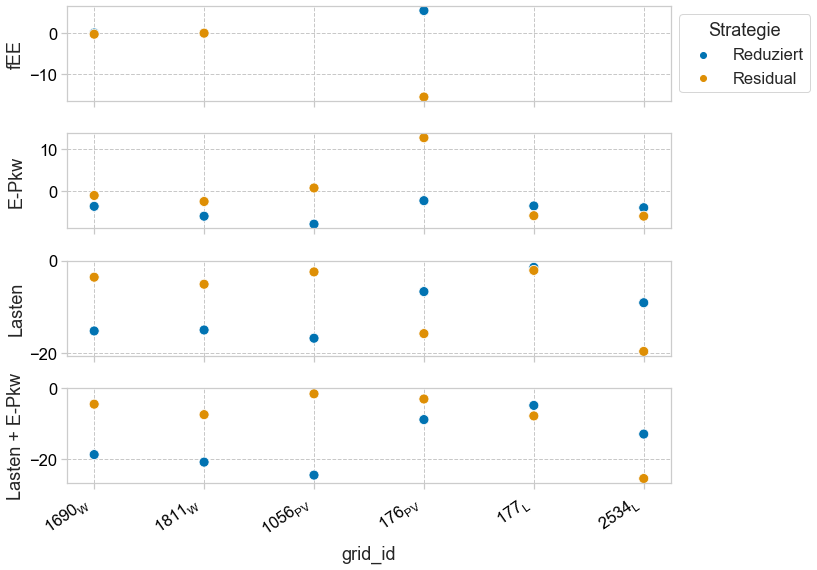

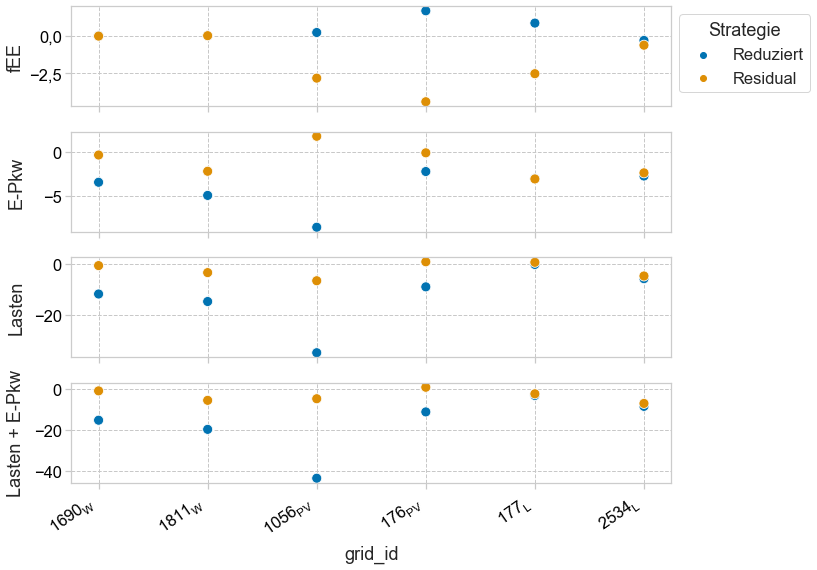

In [42]:
strategies_df = results_diff_percental_df.loc[idx["curtailment_results_weekly", :, :, :], :]

for week in weeks:
    weeks_df = strategies_df.loc[idx[:, :, :, week], :]
    
    fig, axs = plt.subplots(
        4, 1, figsize=standard_sizes["a4landscape"], sharex=True)
    
#     fig.suptitle(title_dict[week], x=0.45)

    for count, col in enumerate(strategies_df.columns):
        ax = axs[count]

        plot_df = weeks_df[[col]].reset_index()

        plot_df = plot_df.assign(
            sortby=plot_df.grid_id.map(sorting_dict))
        
        plot_df = plot_df.sort_values(
            by="sortby", ascending=True).drop("sortby", axis=1)
        
        plot_df.grid_id = plot_df.grid_id.map(naming_dict)

        sns.scatterplot(
            data=plot_df, x="grid_id", y=col, hue="strategy", s=100, ax=ax)
        
        # y limits
        ylim = ax.get_ylim()
        
        if ylim[1] < 0:
            ylim = (ylim[0], 0)
            ax.set_ylim(ylim)
        
        # axis labels
        ax.set_ylabel(yaxis_labels_dict[col])
        
        if count == 2:
            ax.set_xlabel("Netz ID")
            
            plt.xticks(rotation=35, ha="right")
        
        # legend
        if count == 0:
            handles, labels = ax.get_legend_handles_labels()
            labels = [legend_dict[label] for label in labels]
            
            ax.legend(
                handles=handles, labels=labels,
                bbox_to_anchor=(1,1), loc="upper left", title="Strategie")
        else:
            ax.get_legend().remove()
    
    fig.align_ylabels()

    plt.tight_layout()

    for kind in figure_export_as:
        plt.savefig(
            os.path.join(export_dir, f"{week}_curtailment_diff_per_strategy_per_week.{kind}"),
            dpi=450, bbox_inches="tight")

    plt.show()

#### per type

In [43]:
yaxis_label_dict = {
    "min_rl": "Niedrige RL",
    "max_rl": "Hohe RL"}

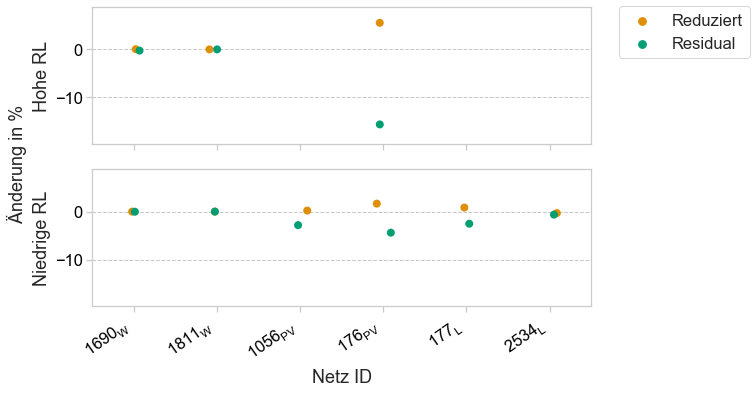

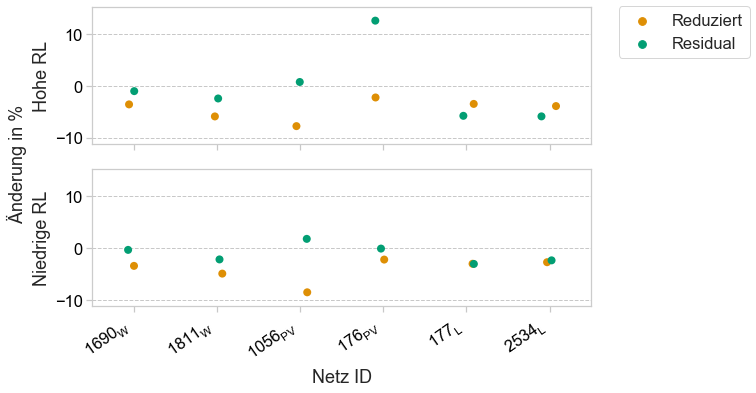

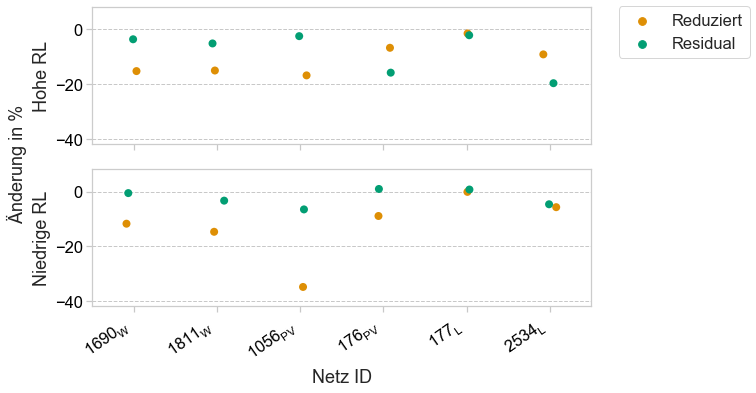

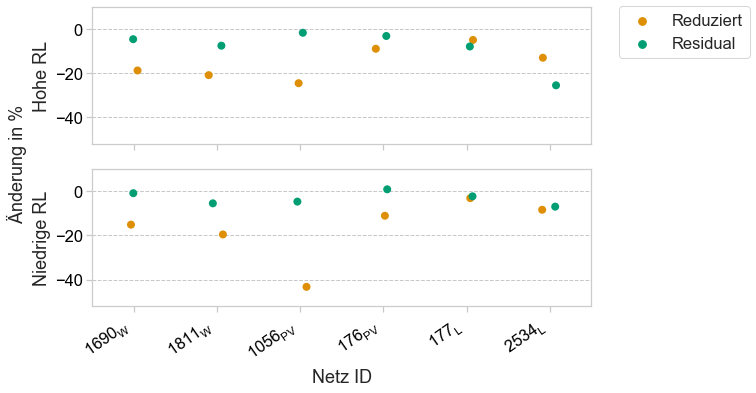

In [44]:
for count_cols, col in enumerate(strategies_df.columns):
    plot_df = strategies_df[[col]]
    
    fig, axs = plt.subplots(
        2, 1, figsize=standard_sizes["a5landscape"], sharex=True)
    
    for count, week in enumerate(weeks):
        weeks_df = plot_df.loc[idx[:, :, :, week], :]

        ax = axs[count]

        weeks_df = weeks_df[[col]].reset_index()

        weeks_df = weeks_df.assign(
            sortby=weeks_df.grid_id.map(sorting_dict))
        
        weeks_df = weeks_df.sort_values(
            by="sortby", ascending=True).drop("sortby", axis=1)
        
        weeks_df.grid_id = weeks_df.grid_id.map(naming_dict)

        sns.stripplot(
            data=weeks_df, x="grid_id", y=col, hue="strategy", s=8, ax=ax, palette=palette[1:3])
        
        # y limits
        ax.set_ylim(ylimits[col])
        
        # axis labels
        ax.set_ylabel(yaxis_label_dict[week])
        
        if count == 1:
            ax.set_xlabel("Netz ID")
            
            plt.xticks(rotation=35, ha="right")
        else:
            ax.set_xlabel(None)
        
        # legend
        if count == 1:
            handles, labels = ax.get_legend_handles_labels()
            labels = [legend_dict[label] for label in labels]

            leg = plt.figlegend(
                handles=handles, labels=labels,
                bbox_to_anchor=(1,0.975), loc="upper left")

        ax.get_legend().remove()
            
    fig.text(-0.01, 0.58, 
             "Änderung in %", va='center', rotation='vertical')
    
    fig.align_ylabels()
    plt.tight_layout()

    for kind in figure_export_as:
        plt.savefig(
            os.path.join(export_dir, 
                         f"{yaxis_labels_dict[col]}_curtailment_diff_per_strategy_per_type.{kind}"),
            dpi=450, bbox_inches="tight")

    plt.show()

### Curtailment plots strategies + solar storage

In [45]:
sorting_dict_2 = {
    "reduced curtailment_results_weekly": 0,
    "residual curtailment_results_weekly": 1,
    "dumb curtailment_results_weekly_with_solar_storage": 2,
    "reduced curtailment_results_weekly_with_solar_storage": 3,
    "residual curtailment_results_weekly_with_solar_storage": 4}

In [46]:
legend_dict = {
    "reduced curtailment_results_weekly": "Reduziert",
    "residual curtailment_results_weekly": "Residual",
    "dumb curtailment_results_weekly_with_solar_storage": "Ungesteuert",
    "reduced curtailment_results_weekly_with_solar_storage": "Reduziert",
    "residual curtailment_results_weekly_with_solar_storage": "Residual"}

frame_dict = {
    "edgecolor": "black",
    "linewidth": 1.3}

frame_dict_ess = {
    "edgecolor": "#99ccff",
    "linewidth": 1.3}

In [47]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color="w")]

legend_elements.extend(Line2D([0], [0], marker='o', color="w", markerfacecolor=color, markersize=8)
                  for color in palette[1:3])

legend_elements.append(Line2D([0], [0], marker='o', color="w"))

legend_elements.extend(Line2D([0], [0], marker='D', color="w", markerfacecolor=color, markersize=8)
                  for color in palette[:3])

In [48]:
legend_labels = ["Ohne ESS", "Reduziert", "Residual", "Mit ESS", "Ungesteuert", "Reduziert", "Residual"]

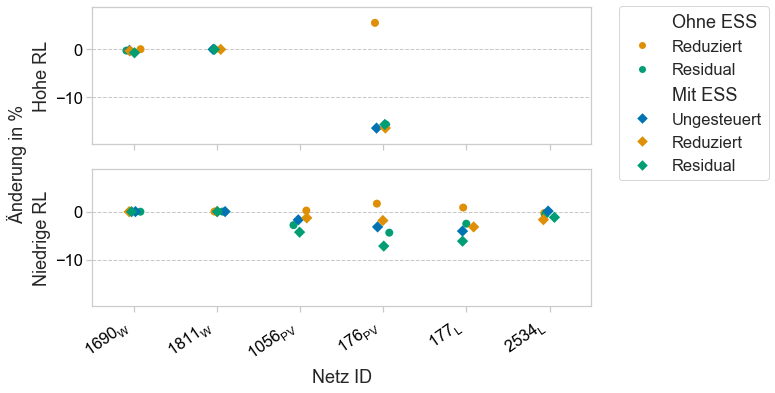

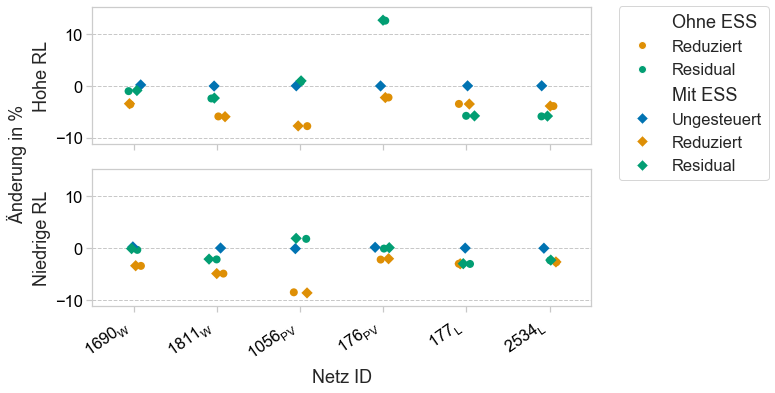

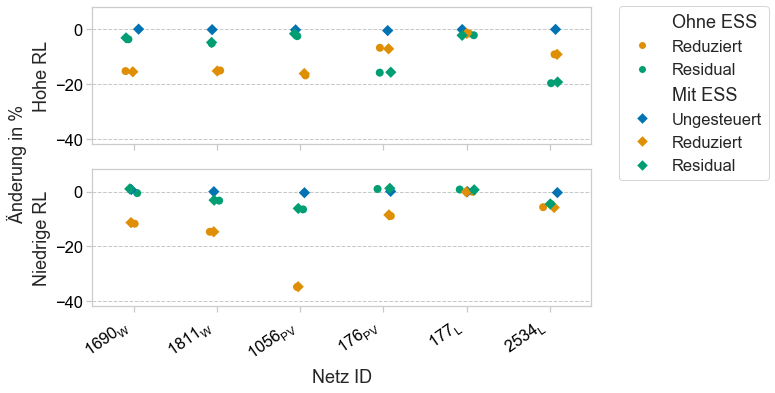

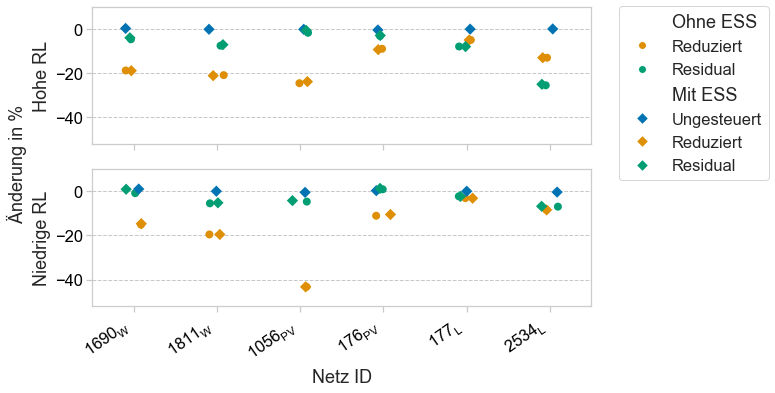

In [49]:
for count_cols, col in enumerate(results_diff_percental_df.columns):
    plot_df = results_diff_percental_df[[col]]
    
    fig, axs = plt.subplots(
        2, 1, figsize=standard_sizes["a5landscape"], sharex=True)
    
    for count, week in enumerate(weeks):
        weeks_df = plot_df.loc[idx[:, :, :, week], :]

        ax = axs[count]

        weeks_df = weeks_df[[col]].reset_index()
        
        weeks_df = weeks_df.assign(
            full_strategy=weeks_df.strategy + " " + weeks_df.curtailment_dir)

        weeks_df = weeks_df.assign(
            sortby=weeks_df.grid_id.map(sorting_dict),
            sortby2=weeks_df.full_strategy.map(sorting_dict_2))
        
        weeks_df = weeks_df.sort_values(
            by=["sortby", "sortby2"]).drop(["sortby", "sortby2"], axis=1)
        
        weeks_df.grid_id = weeks_df.grid_id.map(naming_dict)
        
        bool_s = (weeks_df.curtailment_dir == "curtailment_results_weekly")

        sns.stripplot(
            data=weeks_df.loc[bool_s], x="grid_id",
            y=col, hue="full_strategy", ax=ax, s=8,
            palette=palette[1:3])
        
        sns.stripplot(
            data=weeks_df.loc[~bool_s], x="grid_id", s=8,
            y=col, hue="full_strategy", ax=ax, marker="D")
        
        # y limits
        ax.set_ylim(ylimits[col])
        
        # axis labels
        ax.set_ylabel(yaxis_label_dict[week])
        
        if count == 1:
            ax.set_xlabel("Netz ID")
            
            plt.xticks(rotation=35, ha="right")
        else:
            ax.set_xlabel(None)
            
        # legend
        if count == 0:
            ax.get_legend().remove()
            leg = plt.figlegend(
                handles=legend_elements, labels=legend_labels,
                bbox_to_anchor=(1,0.975), loc="upper left")
            
            # change font size
            texts = leg.get_texts()
            for text in texts:
                text._fontproperties = texts[0]._fontproperties.copy()
                
            for i in [0, 3]:
                texts[i].set_size(18)
        else:
            ax.get_legend().remove()
            
    fig.text(-0.01, 0.58, 
             "Änderung in %", va='center', rotation='vertical')
    
    fig.align_ylabels()
    plt.tight_layout()

    for kind in figure_export_as:
        plt.savefig(
            os.path.join(export_dir, 
                         f"{yaxis_labels_dict[col]}_curtailment_diff_per_type.{kind}"),
            dpi=450, bbox_inches="tight")

    plt.show()